## 1. Isolation forest

Isolation forest is an unsupervised learning algorithm that is used for anomaly detection.
It works by isolating the outliers in the data. It is based on the fact that anomalies are
data points that are few and different. The algorithm works by randomly selecting a feature
and then randomly selecting a split value between the maximum and minimum values of the
selected feature. The number of splits required to isolate a data point is equivalent to the
path length from the root node to the terminating node. This path length is averaged over a
forest of such random trees. The average path length is then converted to an anomaly score.
The lower the score, the more abnormal the data point is.

## 2. KPIs dataset

Import the libraries

In [134]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import average_precision_score

Import the dataset

In [135]:
kpi = pd.read_csv('KPIs for telecommunication.csv', sep=';')

### Exploratory data analysis

General information

In [136]:
kpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   KPI1    1365 non-null   float64
 1   KPI2    1365 non-null   float64
 2   KPI3    1365 non-null   int64  
 3   KPI4    864 non-null    float64
 4   KPI5    1365 non-null   int64  
 5   KPI6    1083 non-null   float64
 6   KPI7    1365 non-null   int64  
 7   KPI8    1365 non-null   float64
 8   KPI9    983 non-null    float64
 9   KPI10   1365 non-null   int64  
dtypes: float64(6), int64(4)
memory usage: 106.8 KB


In [137]:
# Descriptive statistics
print(kpi.describe())

              KPI1         KPI2          KPI3        KPI4          KPI5  \
count  1365.000000  1365.000000  1.365000e+03  864.000000  1.365000e+03   
mean     75.914277    14.966571  3.427450e+07   99.964796  7.614980e+06   
std      42.347881    33.294258  9.851706e+07    0.703317  1.903238e+07   
min       0.000000     0.000000  0.000000e+00   80.000000  0.000000e+00   
25%      92.308000     0.000000  9.090000e+02  100.000000  8.580000e+02   
50%     100.000000     1.500000  3.012590e+05  100.000000  1.745170e+05   
75%     100.000000    17.010000  1.795968e+07  100.000000  5.163472e+06   
max     100.000000   472.980000  1.436894e+09  100.000000  2.199998e+08   

              KPI6          KPI7         KPI8        KPI9         KPI10  
count  1083.000000  1.365000e+03  1365.000000  983.000000  1.365000e+03  
mean      0.434573  3.715659e+04     0.038443   99.931988  4.219081e+07  
std       2.896761  8.830922e+04     0.689574    0.743147  1.116678e+08  
min       0.000000  0.000000

Check for missing values

In [138]:
kpi.isnull().sum()

KPI1       0
KPI2       0
KPI3       0
KPI4     501
KPI5       0
KPI6     282
KPI7       0
KPI8       0
KPI9     382
KPI10      0
dtype: int64

Replace missing values with 0 at this state, we will use a more advanced method later.

In [139]:
kpi = kpi.fillna(kpi.mean())

Boxplots

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


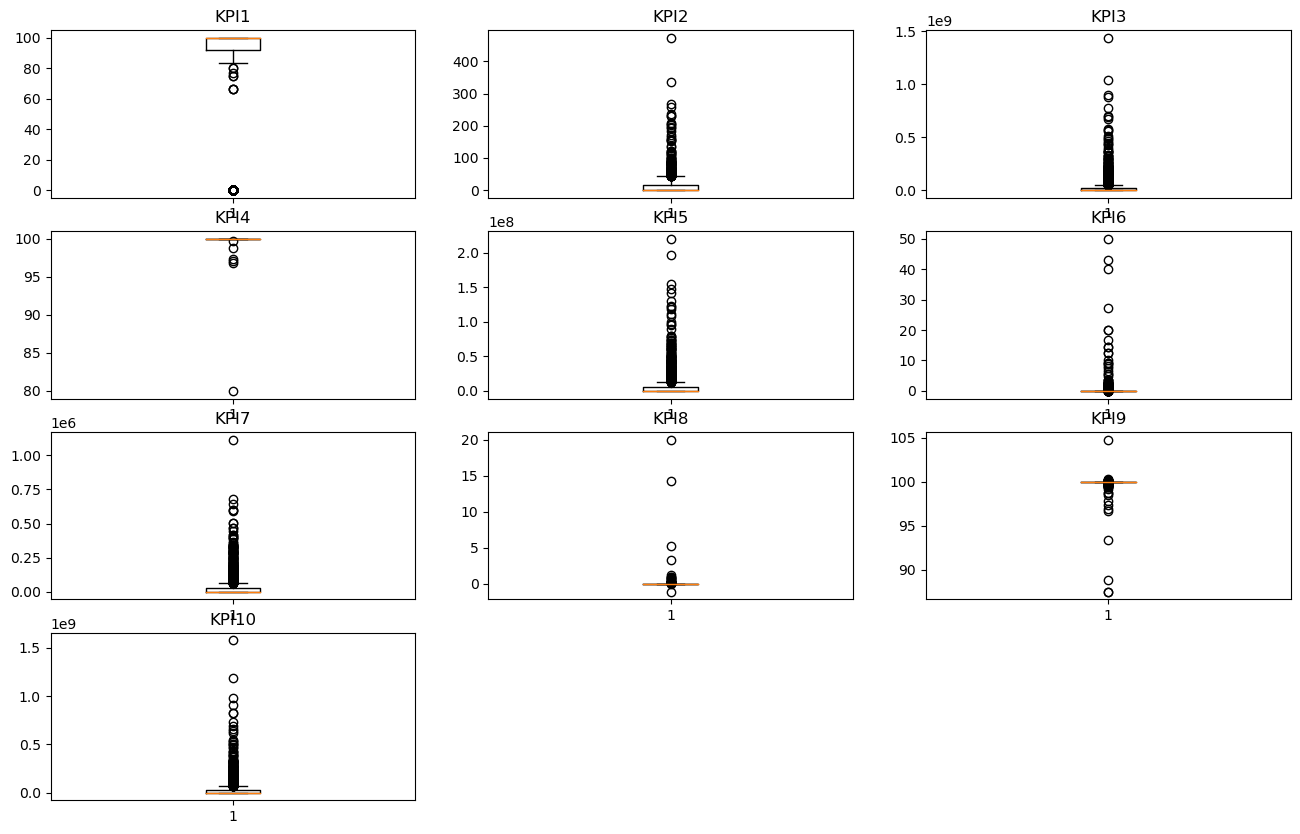

In [140]:
ax, fig = plt.subplots(figsize=(16, 10))
for i in range(0, 10):
    plt.subplot(4, 3, i + 1)
    plt.boxplot(kpi.iloc[:, i])
    plt.title(kpi.columns[i])
plt.show()

We can see that there are outliers in different columns.
We will use the isolation forest algorithm to detect them.

<Figure size 1600x1000 with 0 Axes>

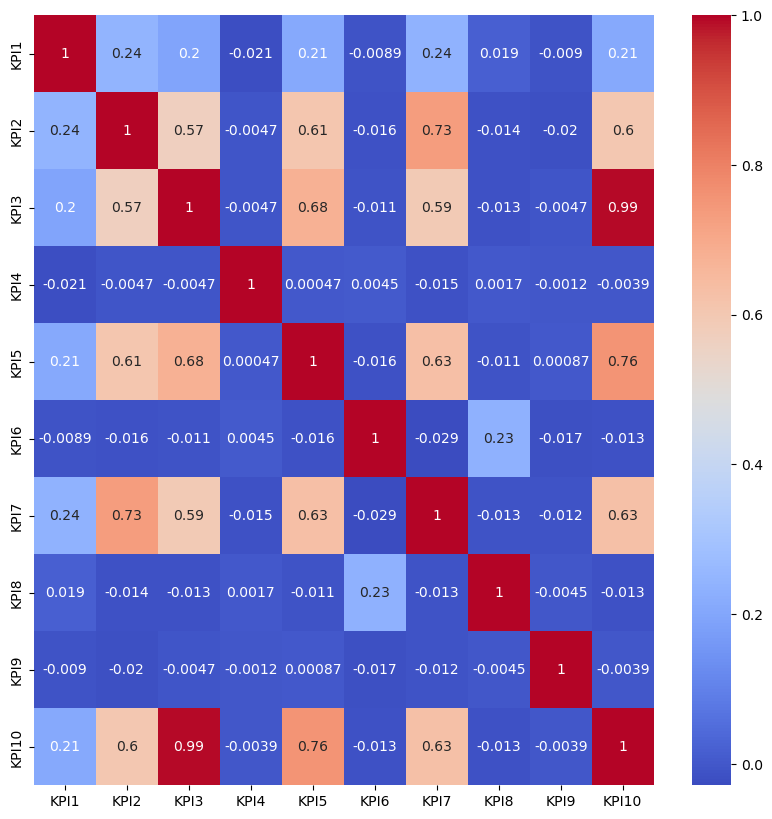

In [141]:
# Plot correlations heatmap
plt.figure(figsize=(16, 10))
plt.figure(4, figsize=(10, 10))
sns.heatmap(kpi.corr(), annot=True, cmap="coolwarm")
plt.show()

### Data preprocessing

Remove features that represent a correlation > 0.5

In [142]:
kpi = kpi.drop(['KPI10'], axis=1)
kpi = kpi.drop(['KPI7'], axis=1)
kpi = kpi.drop(['KPI5'], axis=1)
kpi = kpi.drop(['KPI3'], axis=1)

Split the data into train and test sets

In [143]:
X_train, X_test = train_test_split(kpi, test_size=0.3, random_state=1234)

### Model training

In [144]:
iforest = IsolationForest(random_state=1234)
iforest.fit(X_train)

IsolationForest(random_state=1234)

In [145]:
# Predict the outliers
y_pred = iforest.predict(X_test)
X_test['anomaly_score'] = iforest.decision_function(X_test)
X_test['anomaly'] = y_pred

In [146]:
# Print the top 5 outliers
print("Top 5 by anomaly score:")
print(X_test.loc[X_test['anomaly'] == -1].sort_values(by=['anomaly_score'], ascending=False).head())

Top 5 by anomaly score:
         KPI1    KPI2     KPI4   KPI6   KPI8     KPI9  anomaly_score  anomaly
660    99.615   27.99   97.297  0.490  0.000  100.000      -0.002440       -1
728   100.000  202.02  100.000  0.000  0.000  100.000      -0.006432       -1
1061    0.000    9.51  100.000  0.000  0.000  100.000      -0.016395       -1
504   100.000   36.00  100.000  0.000  0.000   97.368      -0.017326       -1
811    99.657  171.51  100.000  0.103  0.054  100.000      -0.018247       -1


In [147]:
# Print the record of bottom 5 outliers of the test data
print("Bottom 5 by anomaly score:")
print(X_test.loc[X_test['anomaly'] == -1].sort_values(by=['anomaly_score']).head())

Bottom 5 by anomaly score:
       KPI1   KPI2   KPI4    KPI6   KPI8   KPI9  anomaly_score  anomaly
232  88.889   0.00  100.0  14.286  20.00  100.0      -0.270610       -1
691  98.765  28.50  100.0   3.297   0.00   87.5      -0.186617       -1
100  66.667   0.00  100.0  12.500   0.00  100.0      -0.102328       -1
205  90.909   0.00  100.0  16.667   0.00  100.0      -0.101615       -1
586  98.901  35.01  100.0   0.917   0.99  100.0      -0.084750       -1


The figure layout has changed to tight


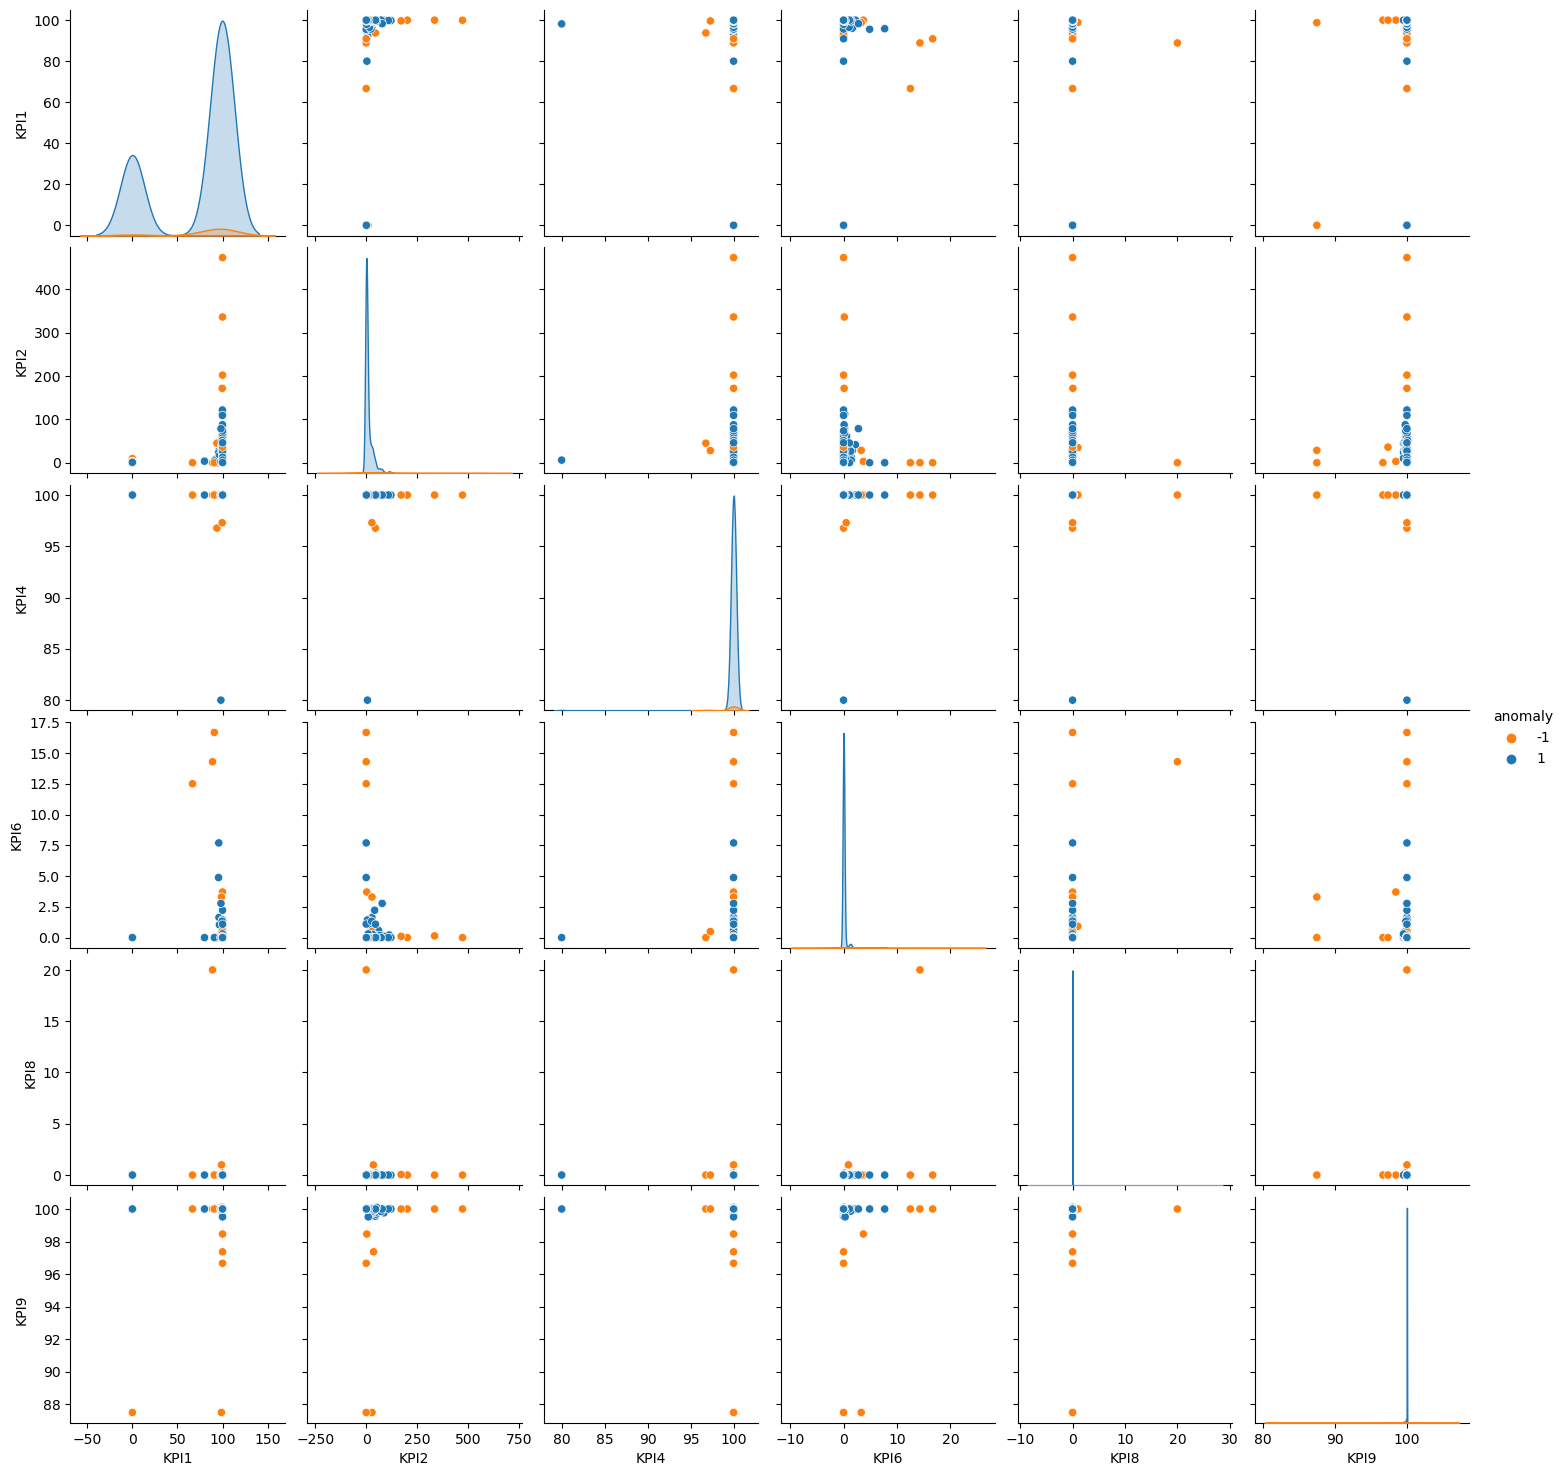

In [148]:
# Pairplot of the features
features = ['KPI1', 'KPI2', 'KPI4', 'KPI6', 'KPI8', 'KPI9', 'anomaly']
palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(X_test[features], hue='anomaly', palette=palette)
plt.show()

The above plot allows us to see all the points along the different axis, and this gives us a great visual idea of where the outliers are situated.

In general, the isolation forest did a good job, the outliers are well outside the cluster of the normal values in at least one of the graphs. To make sure of it, it would have been optimal to labe all the points to know where they are exactly on each plot, but seeing there are a lot of them, we will plot just one anomaly and show you what we mean.

The figure layout has changed to tight


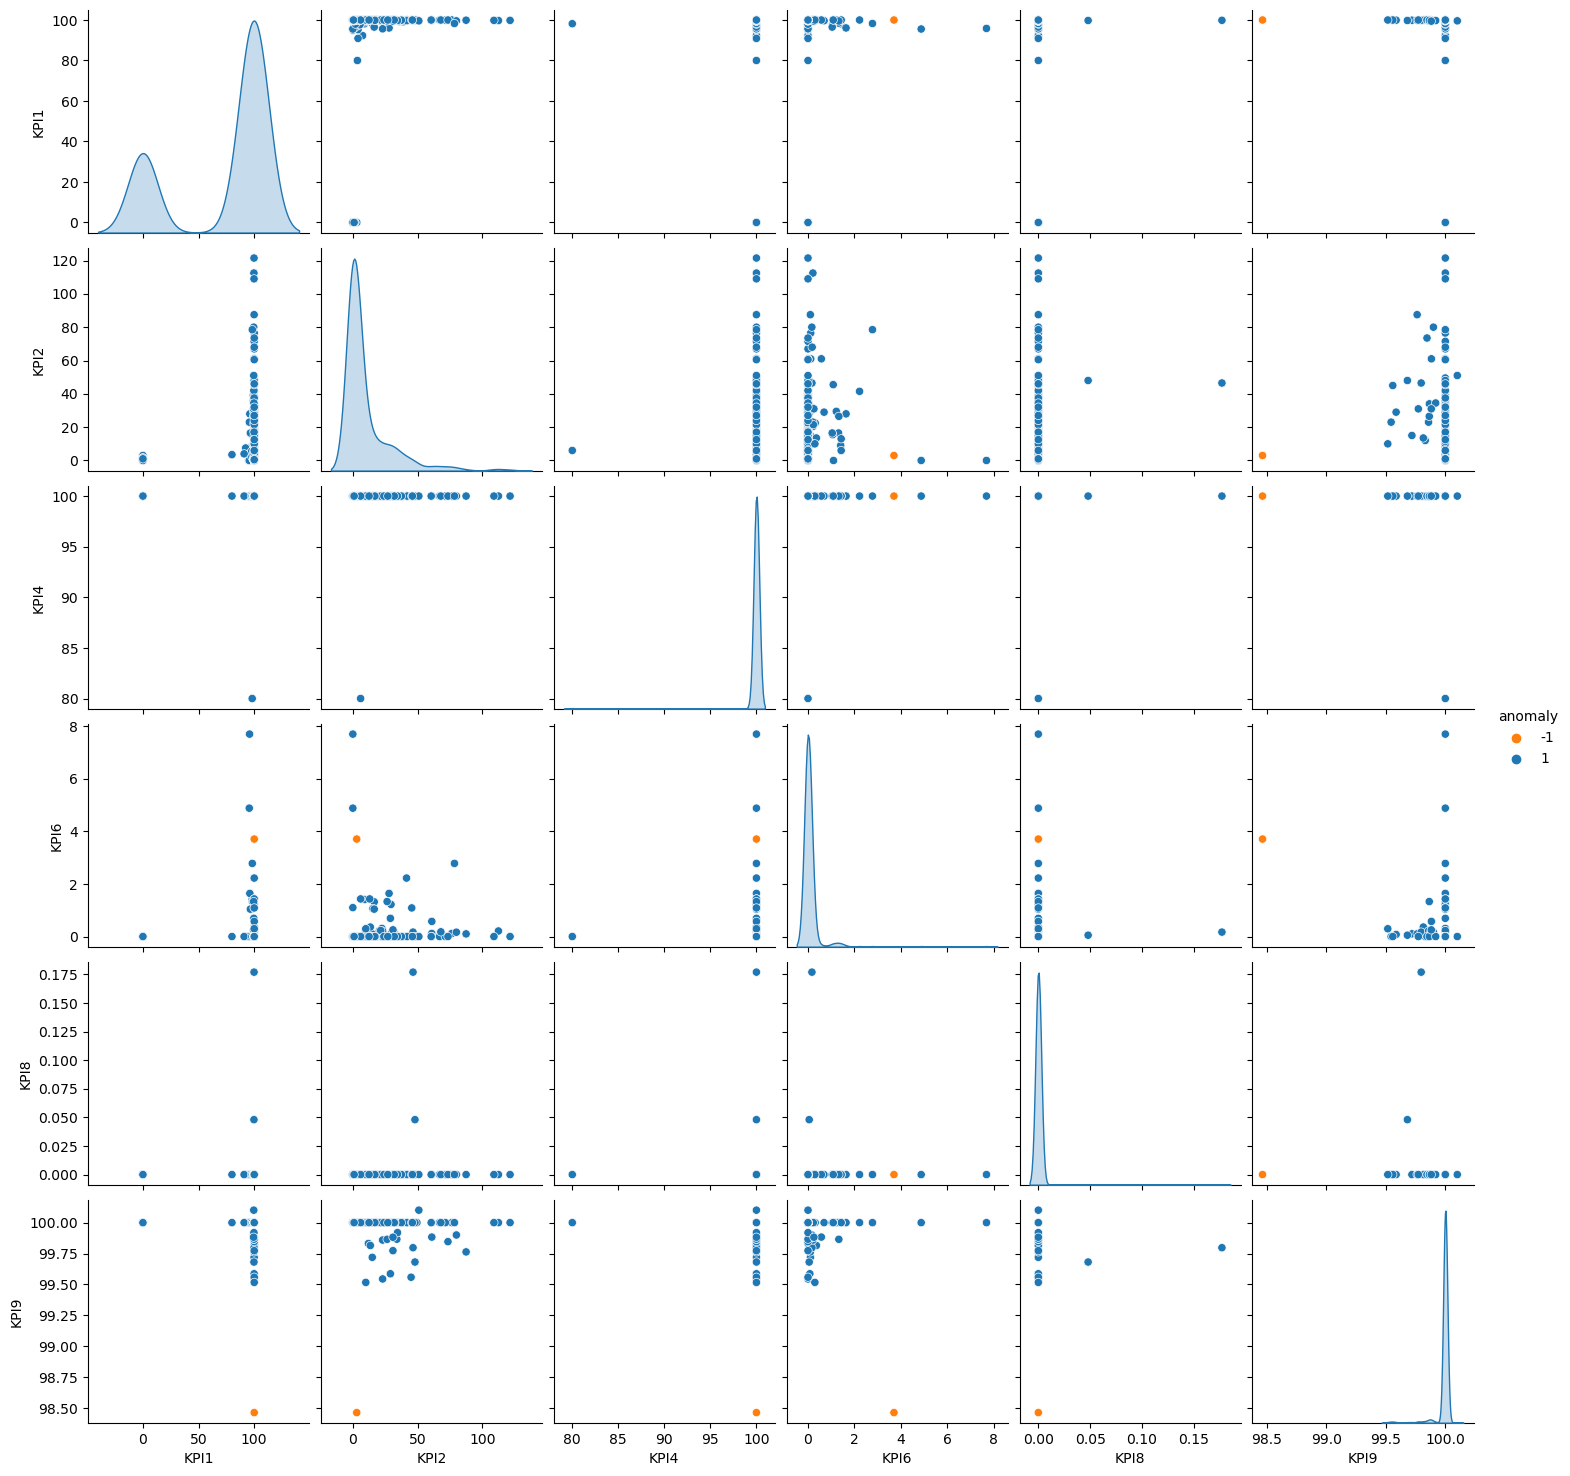

In [149]:
outliers = X_test.loc[X_test['anomaly'] == -1].head(1)
normal = X_test.loc[X_test['anomaly'] == 1]
points = pd.concat([outliers, normal])
sns.pairplot(points[features], hue='anomaly', palette=palette)
plt.show()

Plotting a single anomaly, we can see clearly why it's classified as one, we can simply look at the graphs containing the feature `KPI9`.

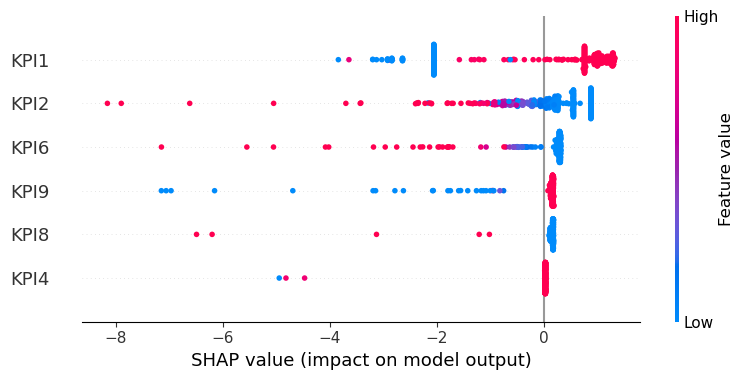

In [150]:
# SHAP values
shap.initjs()

base_features = ['KPI1', 'KPI2', 'KPI4', 'KPI6', 'KPI8', 'KPI9']

explainer = shap.TreeExplainer(iforest)
shap_values = explainer.shap_values(X_test[base_features])

shap.summary_plot(shap_values, X_test[base_features])

The above plot is the summary of SHAP (SHapley Additive exPlanations) approach to identify the contributions of features to the overall output of the model.

This gives us key insights on determining what causes anomalies in the network. For instance:
- A high value of `KPI1` suggests an anomaly. Same for `KPI4` and `KPI9`. The first 2 have the most significant effect.
- Whereas, a low value of `KPI2`, `KPI6` or `KPI8` suggests an anomaly, opposite to the other features.

One last thing that we should keep in mind is the problem of missing values, here we chose to assign them the values of the mean, which may have affected the results seeing there is a good chunk of values missing.